In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [3]:
tf.random.set_seed(12345)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [5]:
f = h5py.File("mercado_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [6]:
scaled_X

masked_array(
  data=[[0.3028322440087146],
        [0.30718954248366015],
        [0.2984749455337691],
        [0.2701525054466231],
        [0.2962962962962963],
        [0.27450980392156865],
        [0.2505446623093682],
        [0.2505446623093682],
        [0.23965141612200436],
        [0.21350762527233116],
        [0.20043572984749455],
        [0.19825708061002179],
        [0.18736383442265794],
        [0.224400871459695],
        [0.20261437908496735],
        [0.18300653594771243],
        [0.1917211328976035],
        [0.20043572984749455],
        [0.21132897603485837],
        [0.21350762527233116],
        [0.20043572984749455],
        [0.2222222222222222],
        [0.22657952069716777],
        [0.23093681917211328],
        [0.22875816993464054],
        [0.25272331154684097],
        [0.2222222222222222],
        [0.20043572984749455],
        [0.19389978213507628],
        [0.2047930283224401],
        [0.224400871459695],
        [0.23965141612200436],
        

In [7]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

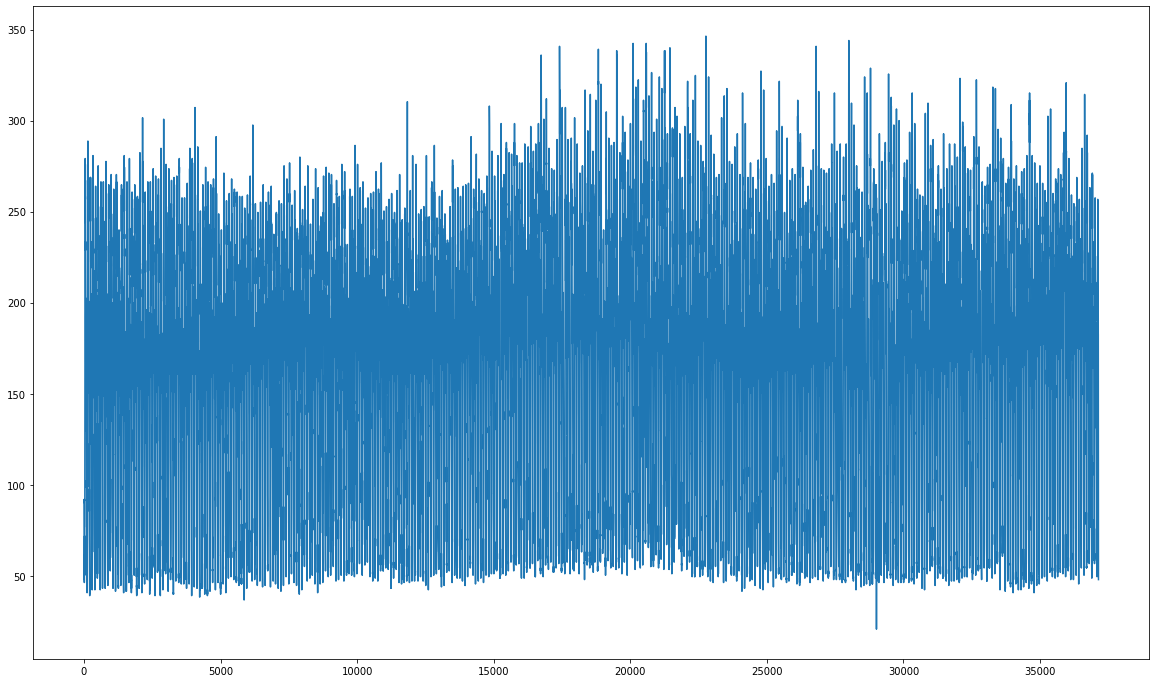

In [8]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.show()

In [9]:
def partitionSet(test_fraction, data, partitions):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partitions/100)*lenX):int((partitions/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partitions/100)*lenX)-1],data[int((partitions/100)*lenX)+test_size:]))
    train_df[int((partitions/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

partitions=75

for i in range(1, partitions):
    [train_df,test_df] = partitionSet(0.25,scaled_X,i)
    train_dataf.append(train_df)
    test_dataf.append(test_df)

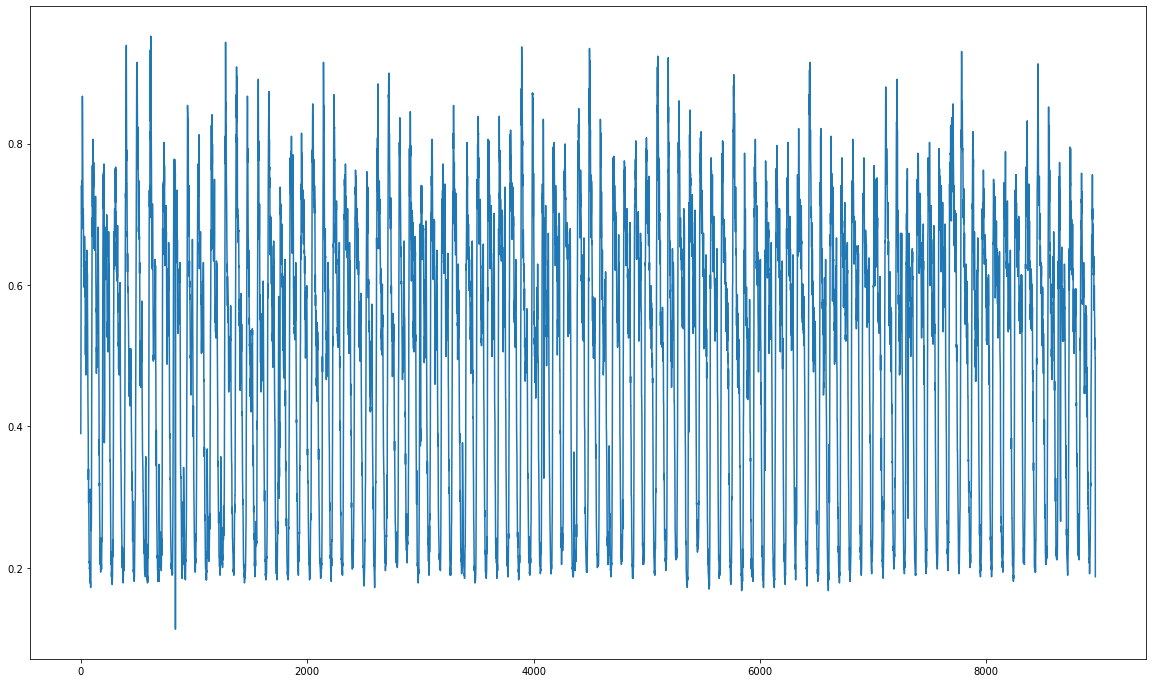

In [10]:
plt.plot(test_dataf[73])
plt.show()

In [ ]:
def Dataset(train, test, timesteps):
    X_train = ma.array([train[t:t+timesteps] for t in range(0,len(train)-timesteps)])
    y_train = train[timesteps:, :]
    X_test = ma.array([test[t:t+timesteps] for t in range(0,len(test)-timesteps)])
    y_test = test[timesteps:, :]
    return X_train, y_train, X_test, y_test

train_X_data = []
train_Y_data = []
test_X_data = []
test_Y_data = []


for j in range(0, len(train_dataf)):
    [train_X_dates,train_Y_dates,test_X_dates,test_Y_dates]=Dataset(train_dataf[j],test_dataf[j], 48)
    train_X_data.append(train_X_dates)
    train_Y_data.append(train_Y_dates)
    test_X_data.append(test_X_dates)
    test_Y_data.append(test_Y_dates)

In [ ]:
with open('train_X_data.npy', 'wb') as f:
    np.save(f, [train_X_data[i] for i in range(0, len(train_dataf))])

In [ ]:
with open('train_Y_data.npy', 'wb') as f:
    np.save(f, [train_Y_data[i] for i in range(0, len(train_dataf))])

In [ ]:
with open('test_X_data.npy', 'wb') as f:
    np.save(f, [test_X_data[i] for i in range(0, len(train_dataf))])

In [ ]:
with open('test_Y_data.npy', 'wb') as f:
    np.save(f, [test_Y_data[i] for i in range(0, len(train_dataf))])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=6, min_delta=0.00001, mode='min')

In [ ]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit, earlystopping, i):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    opt = Adam(learning_rate = 0.00004)
    model.compile(loss = 'mse', optimizer=opt)
    X_ = ma.filled(train_X_data[i],0)
    Y_ = ma.filled(train_Y_data[i],0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False,
                      callbacks=[earlystopping])
    return model, MODEL

In [ ]:
df_train = []
df_validation = []
models = []

datasets = np.arange(0,partitions-1)

for j in datasets:
    [model, MODEL] = LSTM_function(64,np.shape(train_X_data[0])[1], 1, 0.2, 100, 256, 0.2, early_stopping, j)
    df_train.append(MODEL.history['loss'])
    df_validation.append(MODEL.history['val_loss'])
    models.append(model)
    model.summary()

In [ ]:
for i in datasets:
    models[i].save('/home/costa/Institute/ModelsForAlicante/MercAlic/models/MercAlicModel'+str(i)+'.h5')

In [ ]:
train_performance = []
for i in datasets:
    train_performance.append(np.array(df_train[i]))

In [ ]:
val_performance = []
for i in datasets:
    val_performance.append(np.array(df_validation[i]))

In [ ]:
with open('train_performance.npy', 'wb') as f:
    np.save(f, [train_performance[i] for i in datasets] )

In [ ]:
with open('val_performance.npy', 'wb') as f:
    np.save(f, [val_performance[i] for i in datasets])

In [1]:
import re #python regular expression matching module
script = re.sub(r'# In\[.*\]:\n','',open('3.0-Model.py').read())
with open('3.0-ModelScript.py','w') as fh:
    fh.write(script)